In [24]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "../data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
ALL_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]

SELECTED_POSITIONS = TRAIN_POSITIONS + TEST_POSITIONS

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [21]:
def load_selected_csvs(base_dir):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def extract_features(window, cols):
    feats = []

    for c in cols:
        x = window[c].values

        # Time-domain features
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.sum(np.abs(x)) / len(x)
        ])

        # Frequency-domain features
        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals) / len(fft_vals)

        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])

    return feats

def build_dataset(dfs, feature_cols, selected_positions):
    X, y, positions = [], [], []
    for df in dfs:
        if df["phone_position"].iloc[0] not in selected_positions:
            continue
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            positions.append(w["phone_position"].iloc[0])
    return np.array(X), np.array(y), np.array(positions)

In [20]:
def evaluate_knn(X_train, y_train, X_test, y_test, title):
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"No data for {title}, skipping evaluation.")
        return None

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ])

    param_grid = {
        "knn__n_neighbors": list(range(3, 16, 2)), 
        "knn__weights": ["uniform", "distance"],
        "knn__metric": ["euclidean", "manhattan", "cosine"]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        error_score=0
    )

    grid.fit(X_train, y_train)

    print(f"\nBest parameters for {title}:")
    print(grid.best_params_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n=== {title} ===")
    unique_labels = np.unique(y_test)
    print(classification_report(y_test, y_pred, labels=unique_labels, digits=4, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, cmap="Oranges")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1": f1_score(y_test, y_pred, average="macro", zero_division=0)
    }

Loaded 40 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand']
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best parameters for KNN Raw Device-Frame Features (Cross-Position):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== KNN Raw Device-Frame Features (Cross-Position) ===
              precision    recall  f1-score   support

         run     0.7799    0.9920    0.8732       250
         sit     1.0000    1.0000    1.0000       250
      stairs     0.8632    0.6431    0.7371       255
        walk     0.9150    0.9040    0.9095       250

    accuracy                         0.8836      1005
   macro avg     0.8895    0.8848    0.8799      1005
weighted avg     0.8894    0.8836    0.8792      1005



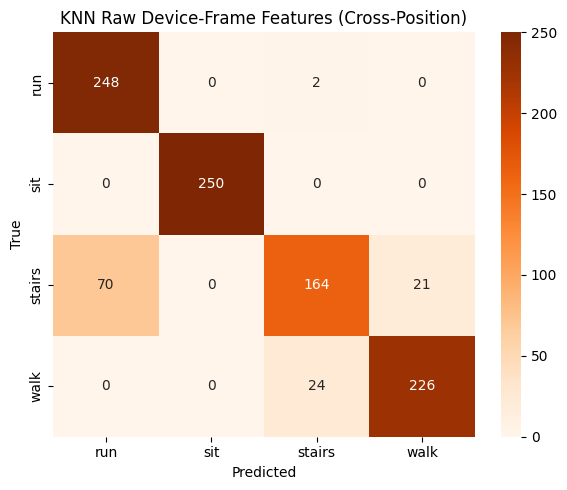

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best parameters for KNN GFT Axis-wise Features (Cross-Position):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== KNN GFT Axis-wise Features (Cross-Position) ===
              precision    recall  f1-score   support

         run     0.9345    0.6280    0.7512       250
         sit     1.0000    1.0000    1.0000       250
      stairs     0.6948    0.8392    0.7602       255
        walk     0.8925    0.9960    0.9414       250

    accuracy                         0.8657      1005
   macro avg     0.8805    0.8658    0.8632      1005
weighted avg     0.8795    0.8657    0.8627      1005



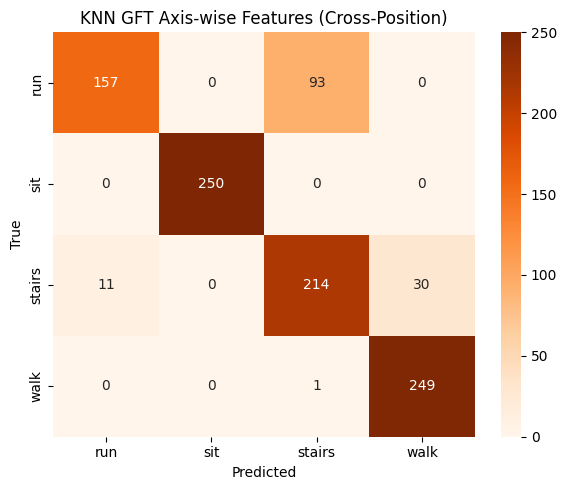


========== SUMMARY ==========
Activities: ['sit', 'walk', 'run', 'stairs']
Train Positions: ['dom_hand']
Test Positions: ['nondom_hand']
Raw Device-Frame Features: {'precision': 0.889502966414585, 'recall': 0.8847843137254902, 'f1': 0.8799437071869418}
GFT Axis-wise Features: {'precision': 0.8804505306521435, 'recall': 0.8658039215686275, 'f1': 0.8632020454763542}


In [25]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_train_raw, y_train_raw, _ = build_dataset(recordings, RAW_FEATURES, TRAIN_POSITIONS)
    X_test_raw, y_test_raw, _ = build_dataset(recordings, RAW_FEATURES, TEST_POSITIONS)
    raw_metrics = evaluate_knn(
        X_train_raw, y_train_raw,
        X_test_raw, y_test_raw,
        "KNN Raw Device-Frame Features (Cross-Position)"
    )

    X_train_gft, y_train_gft, _ = build_dataset(recordings, GFT_FEATURES, TRAIN_POSITIONS)
    X_test_gft, y_test_gft, _ = build_dataset(recordings, GFT_FEATURES, TEST_POSITIONS)
    gft_metrics = evaluate_knn(
        X_train_gft, y_train_gft,
        X_test_gft, y_test_gft,
        "KNN GFT Axis-wise Features (Cross-Position)"
    )

    print("\n========== SUMMARY ==========")
    print("Activities:", SELECTED_ACTIVITIES)
    print("Train Positions:", TRAIN_POSITIONS)
    print("Test Positions:", TEST_POSITIONS)
    print("Raw Device-Frame Features:", raw_metrics)
    print("GFT Axis-wise Features:", gft_metrics)